In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import seaborn as sb
import re

In [3]:
df = pd.read_csv('../data/input/train_v2_drcat_02.csv')

In [4]:
df.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [5]:
df.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [6]:
# topics = ['Distance learning']
topics = df.prompt_name.unique()

In [7]:
df = df[df.prompt_name.isin(topics)].copy()

In [8]:
df.shape

(44868, 5)

In [9]:
n_components = 2*len(topics)
NUMBER_OF_KEYWORDS = 5

In [10]:
def clean_text(text):
    """Function to clean and preprocess text"""
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    #words = word_tokenize(text)  # Tokenize words
    #words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    #return " ".join(words)
    return text

In [11]:
cleaned_data = [clean_text(doc) for doc in df.text.values]

In [12]:
# --------------------------
# Step 2: Vectorize Text Data
# --------------------------
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(cleaned_data)

In [13]:
# --------------------------
# Step 3: Apply LDA
# --------------------------
lda = LatentDirichletAllocation(n_components=n_components, random_state=0)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=30, random_state=0)

In [14]:
# --------------------------
# Step 4: Display Topics
# --------------------------
def display_topics(model, feature_names, num_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))
        print("\n")

# Show topics and top words
print("Topics Identified:")
display_topics(lda, vectorizer.get_feature_names_out(), NUMBER_OF_KEYWORDS)

# make a dictionary with the topics
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    topics["lda_"+str(topic_idx)] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-NUMBER_OF_KEYWORDS - 1:-1]]
    

Topics Identified:
Topic 1:
people advice help make person


Topic 2:
social media health people food


Topic 3:
cars driverless driver car human


Topic 4:
self important people person make


Topic 5:
energy parents children teenagers curfew


Topic 6:
students summer project projects student


Topic 7:
knowledge new imagination use ideas


Topic 8:
students learning online classes school


Topic 9:
electoral college states candidates ensures


Topic 10:
skills develop art music help


Topic 11:
culture park world city parks


Topic 12:
car cars people usage pollution


Topic 13:
like just know think really


Topic 14:
success life working positive goals


Topic 15:
car cars people drive driving


Topic 16:
vote electoral college president people


Topic 17:
car usage limiting cars reduce


Topic 18:
phones phone cell driving use


Topic 19:
technology potential people benefits risks


Topic 20:
face mars natural landform aliens


Topic 21:
school students kids class time


Topic 22:


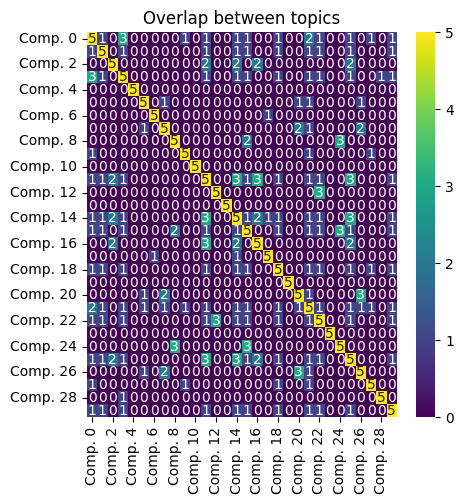

In [20]:
# check the overlap between the topics and visualize in the heatmap
overlap = np.zeros((n_components, n_components))
for i in range(n_components):
    for j in range(n_components):
        overlap[i,j] = len(set(topics[f'lda_{i}']).intersection(set(topics[f'lda_{j}'])))

overlap_df = pd.DataFrame(overlap, columns=[f"Comp. {i}" for i in range(n_components)], index=[f"Comp. {i}" for i in range(n_components)])
plt.figure(figsize=(5, 5))
sb.heatmap(overlap_df, annot=True, cmap='viridis', fmt='g')
plt.title("Overlap between topics")
plt.show()

In [16]:
# for a document, get the topic distribution
doc_topic_dist = lda.transform(doc_term_matrix)
# get the topic with the highest probability for each document
doc_topic = np.argmax(doc_topic_dist, axis=1)
# add the topic to the dataframe
df['topic'] = doc_topic

In [21]:
sb.set_theme(context='notebook', style="whitegrid")

In [63]:
pvt = pd.pivot_table(df, index=["prompt_name"], columns='topic', values='text', aggfunc='count', fill_value=0)

In [64]:
pvt = (pvt.T/pvt.sum(axis=1)).T

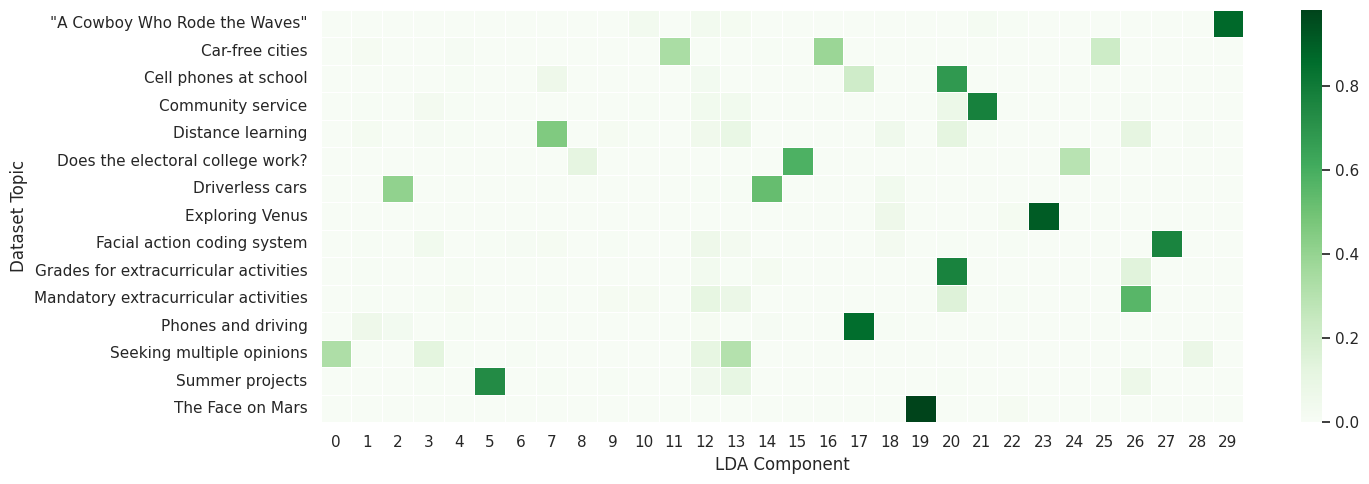

In [65]:
# make heatmap
plt.figure(figsize=(15, 5))
sb.heatmap(pvt, cmap='Greens', linewidth=.5)
plt.xlabel("LDA Component")
plt.ylabel("Dataset Topic")
# sb.despine()
plt.tight_layout()
# plt.show()
plt.savefig(f"../figs/lda_vs_topics_all.pdf")

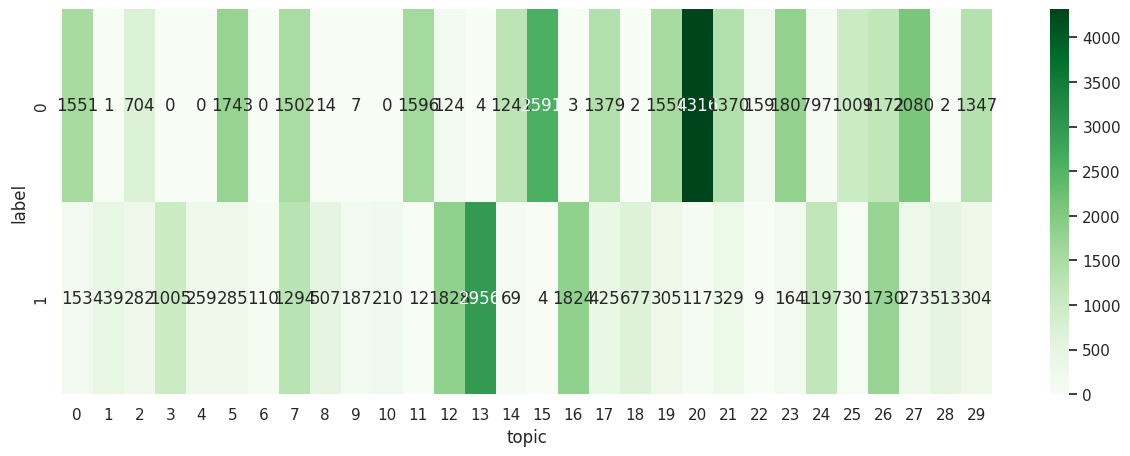

In [76]:
pvt = pd.pivot_table(df, index=["label"], columns='topic', values='text', aggfunc='count', fill_value=0)
# make heatmap
plt.figure(figsize=(15, 5))
sb.heatmap(pvt, annot=True, fmt='d', cmap='Greens')

plt.show()

In [77]:
pvt.index = ['Human', 'LLM']

In [78]:
pvt_partial = pvt[[7, 26, 15, 24]].copy()
pvt_partial = (pvt_partial/pvt_partial.sum())

In [69]:
pvt = (pvt.T/pvt.sum(axis=1)).T

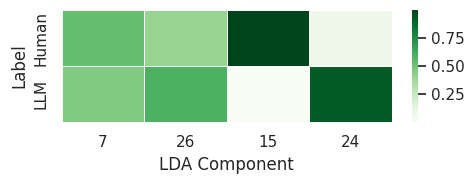

In [79]:
plt.figure(figsize=(5, 2))
sb.heatmap(pvt_partial, cmap='Greens', linewidth=.5)
plt.xlabel("LDA Component")
plt.ylabel("Label")
# sb.despine()
plt.tight_layout()
# plt.show()
plt.savefig(f"../figs/lda_vs_labels_partial.pdf")

In [39]:
df['topic'] = "lda_"+df.topic.astype(str)

In [40]:
df

,text,label,prompt_name,source,RDizzl3_seven,topic
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,lda_17
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,lda_17
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,lda_17
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,lda_17
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,lda_17
...,...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,lda_24
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,lda_24
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,lda_24
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,lda_24


In [41]:
df.to_csv('../data/input/train_v2_drcat_02_lda.csv')

In [58]:
topics

{'lda_0': ['people', 'advice', 'help', 'make', 'person'],
 'lda_1': ['social', 'media', 'health', 'people', 'food'],
 'lda_2': ['cars', 'driverless', 'driver', 'car', 'human'],
 'lda_3': ['self', 'important', 'people', 'person', 'make'],
 'lda_4': ['energy', 'parents', 'children', 'teenagers', 'curfew'],
 'lda_5': ['students', 'summer', 'project', 'projects', 'student'],
 'lda_6': ['knowledge', 'new', 'imagination', 'use', 'ideas'],
 'lda_7': ['students', 'learning', 'online', 'classes', 'school'],
 'lda_8': ['electoral', 'college', 'states', 'candidates', 'ensures'],
 'lda_9': ['skills', 'develop', 'art', 'music', 'help'],
 'lda_10': ['culture', 'park', 'world', 'city', 'parks'],
 'lda_11': ['car', 'cars', 'people', 'usage', 'pollution'],
 'lda_12': ['like', 'just', 'know', 'think', 'really'],
 'lda_13': ['success', 'life', 'working', 'positive', 'goals'],
 'lda_14': ['car', 'cars', 'people', 'drive', 'driving'],
 'lda_15': ['vote', 'electoral', 'college', 'president', 'people'],
 'ld

In [64]:
topkwds = pd.DataFrame.from_dict(topics, orient='index')

In [65]:
topkwds

,0,1,2,3,4
lda_0,people,advice,help,make,person
lda_1,social,media,health,people,food
lda_2,cars,driverless,driver,car,human
lda_3,self,important,people,person,make
lda_4,energy,parents,children,teenagers,curfew
lda_5,students,summer,project,projects,student
lda_6,knowledge,new,imagination,use,ideas
lda_7,students,learning,online,classes,school
lda_8,electoral,college,states,candidates,ensures
lda_9,skills,develop,art,music,help


In [60]:
topkwds.to_csv('../data/input/train_v2_drcat_02_lda_top_keywords.csv')